In [19]:
from bs4 import BeautifulSoup
from pprint import pprint
from urllib import request
# import matplotlib.pyplot as plt
import nltk
import json
import time
import sys
import re

RESOURCES_PATH_LINKS = 'Resources/Corpora/EU/Links/'
RESOURCES_PATH_POSTS = 'Resources/Corpora/EU/Posts/'
RESOURCES_COMPLETE_CORPORA_FILENAME = 'complete_wow_class_posts_dict'


class WowClassesResources:

    def __init__(self):
        None

    WOW_FORUM_ROOT_URL_EU = 'http://eu.battle.net'
    WOW_FORUM_ROOT_URL_US = 'http://us.battle.net'
    WOW_FORUM_MID_URL = '/forums/en/wow/'
    URL_PAGE_ATTRIBUTE = "?page="

    WOW_CLASS_LIST_EU = [('Death Knight', "874789/"),
                      ('Demon Hunter', "19369494/"),
                      ('Druid', "874790/"),
                      ('Hunter', "874791/"),
                      ('Mage', "874792/"),
                      ('Monk', "6038099/"),
                      ('Paladin', "874793/"),
                      ('Priest', "874794/"),
                      ('Rogue', "874795/"),
                      ('Shaman', "874796/"),
                      ('Warlock', "874929/"),
                      ('Warrior', "874930/")]
    WOW_CLASS_LIST_US = [('Death Knight', "1012662/"),
                      ('Demon Hunter', "22813967/"),
                      ('Druid', "1012663/"),
                      ('Hunter', "1012664/"),
                      ('Mage', "1012760/"),
                      ('Monk', "7379141/"),
                      ('Paladin', "1012668/"),
                      ('Priest', "1012666/"),
                      ('Rogue', "1012667/"),
                      ('Shaman', "1012669/"),
                      ('Warlock', "1012670/"),
                      ('Warrior', "1012759/")]

    class GameType:
        # PVP: 2v2 3v3 5v5 cc
        # AB, AV, BET, DR, Efc, EotS, FC, FR, FRR, IoC, LH, LM, Mid, MT, SW, Stags,
        # SoTA, SSM, ST, TB, ToK, TP, TP, WG, WSG, WV, WW, arena
        PVP = 'pvp'
        # PVE: heroic, mythic, mythic+, m+, scenario, boss, mobs, time-walking
        # LFR
        # ZF, WC, VC, DM, Ulda, UBRS, Strat, Stocks, Stockade, ST, AH, SM, SH, SFK, Scholo, RFK, RFD, RFC, MC, Mara, LBRS, Gnomer, DM Warpwood, DM East, BWL, BRD, BFD, AQ40, TAQ, AQ10, RAQ, 
        PVE = 'pve'
        OTHER = 'other'
        PVP_CRITERIA = ['pvp', '2v2', '3v3', '5v5', 'cc',
                        'AB', 'AV', 'BET', 'DR', 'Efc', 'EotS', 'FC', 'FR', 'FRR', 'IoC',
                        'LH', 'LM', 'Mid', 'MT', 'SW', 'Stags', 'SoTA', 'SSM', 'ST', 'TB',
                        'ToK', 'TP', 'TP', 'WG', 'WSG', 'WV', 'WW',
                        'arena']
        PVE_CRITERIA = ['pve', 'heroic', 'mythic', 'mythic+', 'm+', 'scenario', 'boss', 'mobs',
                        'time-walk', 'time-walking'
                        'RFC', 'VC', 'DM', 'WC', 'SFK', 'Stocks', 'Stockade', 'BFD', 'Gnomer', 
                        'SH', 'SM', 'RFK', 'Mara', 'Ulda', 'DM', 'Warpwood', 'DM', 'East', 'Scholo', 
                        'RFD', 'Strat', 'ZF', 'BRD', 'ST', 'AH', 'LBRS', 'UBRS', 'AQ', 'RAQ', 'MC',
                        'BWL', 'AQ40', 'TAQ', 'Ramps', 'BF', 'SP', 'UB', 'MT', 'AC', 'AS', 'Seth',
                        'Seth', 'Halls', 'SV', 'SH', 'Shatt', 'Halls', 'SL', 'Slabs', 'OH',
                        'DH', 'DK', 'Durn', 'Mech', 'Bot', 'Arc', 'BM', 'MgT', 'Terrace', 'MrT',
                        'HoR', 'Naxx', 'OS', 'Sarth', 'Vault', 'VoA', 'Maly',
                        'EoE', 'Uld', 'TC', 'ToC', 'TotC', 'ToGC', '(Heroic)', 'Ony',
                        'RS', 'Hal', 'ICC', 'UK', 'UTK', 'Nexus', 'Nex', 'AZN', 'AN', 'ANK',
                        'OLD', 'AKO', 'OK', 'DTK', 'VH', 'GD', 'HOS', 'Occ', 'HOL', 'UP', 'Culling',
                        'COS', 'Champ', 'ToC', 'FoS', 'PoS', 'TotT', 'BRC', 'SC', 'VP', 'LCoT', 'GB',
                        'HoO', 'H-DM', 'H-VC', 'H-SFK', 'ZA', 'ZG', 'ET', 'WoE', 'HoT', 'BH',
                        'BoT', 'TFW', 'BWD', 'FL', 'DS', 'SH', 'SM', 'Scholo', 'TJS', 'SB', 'MP',
                        'SPM', 'GSS', 'SNT', 'MV', 'HoF', 'TES', 'ToT', 'SoO', 'BSM', 'Auch', 'SR',
                        'GD', 'SBG', 'EB', 'UBRS', 'HM', 'BF', 'BRF', 'HC', 'HFC', 'arc', 'VoW', 'MoS',
                        'CoS', 'EN', 'BRH', 'RtK', 'arc', 'ToV', 'VH', 'CoN', 'EoZ', 'NL', 'HoV', 'GR',
                        'DHT', 'DT']

WOW_TOPIC_URLS_EU = \
    [(c, WowClassesResources.WOW_FORUM_ROOT_URL_EU + WowClassesResources.WOW_FORUM_MID_URL + u)
     for (c, u) in WowClassesResources.WOW_CLASS_LIST_EU]

In [20]:
print(WOW_TOPIC_URLS_EU[0])
url = WOW_TOPIC_URLS_EU[0][1]
# req = request.Request(url)
response = request.urlopen(url)
html = response.read().decode('utf8')
print(html[:100])

('Death Knight', 'http://eu.battle.net/forums/en/wow/874789/')





<html xmlns="http://www.w3.org/1999/xhtml">

<head>
	<meta http-equiv="X-UA-Compatible" content="


In [21]:
def get_page_content(url):
    attempt_number = 0
    while True:
        attempt_number += 1
        if attempt_number > 5:
            return None
        try:
            response = request.urlopen(url)
        except request.HTTPError as e:
            print('HTTPError = ' + str(e.code))
            continue
        except Exception as e:
            print(e)
            continue
        except e:
            print(e)
            continue
        html = response.read().decode('utf8')
        break
    return html


def topic_scrape(forum_url):
    all_links = []
    i = 1
    while True:
        html = get_page_content(forum_url + WowClassesResources.URL_PAGE_ATTRIBUTE + str(i))
        if html is None:
            return []
        bs_html = BeautifulSoup(html, "html.parser")

        all_link_elements = bs_html.find_all("a", class_="ForumTopic")
        # pprint(all_link_elements)
        link_count = len(all_link_elements)
        print(str(i) + ' ' + str(link_count))

        if link_count == 0:
            print('Exiting')
            break
        for a in all_link_elements:
            # print a
            title = a.find(class_='ForumTopic-title').get_text().strip()
            # print title
            all_links.append((a['href'], title))
        i += 1
        time.sleep(3)
    return all_links


def extract_topic(topic_title_url_tuple):
    topic_url_ending = topic_title_url_tuple[0]
    topic_title = topic_title_url_tuple[1]
    pprint('[' + topic_title + '] (' + topic_url_ending + ')')
    all_posts = []
    i = 1
    while True:
        html = get_page_content(
            WowClassesResources.WOW_FORUM_ROOT_URL_EU + topic_url_ending + WowClassesResources.URL_PAGE_ATTRIBUTE + str(
                i))
        if html is None:
            return []
        bs_html = BeautifulSoup(html, "html.parser")

        all_topic_post_elements = bs_html.find_all("div", class_="TopicPost-content")
        # pprint(all_topic_post_elements)
        link_count = len(all_topic_post_elements)
        # print str(i) + ' ' + str(link_count)

        if link_count == 0:
            print('Exiting')
            break
        for element in all_topic_post_elements:
            # print a
            post_body = element.find(class_='TopicPost-bodyContent').get_text().strip()
            post_date = element.find("a", class_='TopicPost-timestamp')['data-tooltip-content']
            author_element = element.find("span", class_='Author-name')
            if author_element is not None:
                # post_author = '<UNKNOWN>'
                if author_element.a is not None:
                    post_author = author_element.a.get_text().strip()
                else:
                    post_author = author_element.get_text().strip()
                all_posts.append((topic_title, post_date, post_author, post_body))
        i += 1
        time.sleep(5)
    pprint('posts: ' + str(len(all_posts)))
    return all_posts


def save_to_json_file(path, file_name, content, mode):
    with open(path + file_name + '.json', mode) as out_file:
        json.dump(content, out_file)


def read_from_json_file(path, file_name):
    try:
        with open(path + file_name + '.json', 'r') as in_file:
            return json.load(in_file)
    except FileNotFoundError as e:
        print('File not found, skipping read for: ' + path + file_name)

In [22]:
# READ CURRENT CLASS TO WORK WITH, READ ALL CORPORA
currentClass = WOW_TOPIC_URLS_EU[0]
print('Current Class: ' + currentClass[0] + ', URL: ' + currentClass[1])
# READ DICTIONARY OF POSTS
posts_by_class = read_from_json_file('Resources/Corpora/EU/Posts/', 'corpora_posts_' + currentClass[0])
print('Number of posts: ' + str(len(posts_by_class[currentClass[0]])))
# print('First post:\n' + posts_by_class[currentClass[0]][0][3])

all_posts_dict = read_from_json_file(RESOURCES_PATH_POSTS, RESOURCES_COMPLETE_CORPORA_FILENAME)
print(all_posts_dict.keys())
for wow_class in all_posts_dict:
    print(wow_class + ': ' + str(len(all_posts_dict.get(wow_class))) + ' posts\t\t' 
          + 'Longest post length: ' + str(max(len(p[3]) for p in all_posts_dict[wow_class])))
    
# print(sys.maxsize)
# posts_with_game_type = {currentClass[0]: []}
from _operator import index

posts_with_game_type_dict = {}

for wow_class in all_posts_dict:
    print('Processing: ' + wow_class)
    posts_with_game_type_dict[wow_class] = []
    i = 0
    for post in all_posts_dict[wow_class]:
        i += 1
        if i % 1000 == 0:
            print("Progress: " + str(i) + '/' + str(len(all_posts_dict[wow_class])))
        
        postBody = post[3]
        post.append(WowClassesResources.GameType.OTHER)
        pvpIndex = sys.maxsize
        pveIndex = sys.maxsize
        
        # find PVP minimum index
        for crit in WowClassesResources.GameType.PVP_CRITERIA:
            critMatch = re.search(r'\b' + crit.lower() + r'\b', postBody.lower())
            if critMatch is not None:
                ind = critMatch.start()
            else:
                continue
            if ind != -1:
                pvpIndex = min(pvpIndex, ind)
        # find PVE minimum index
        for crit in WowClassesResources.GameType.PVE_CRITERIA:
            critMatch = re.search(r'\b' + crit.lower() + r'\b', postBody.lower())
            if critMatch is not None:
                ind = critMatch.start()
            else:
                continue
            if ind != -1:
                pveIndex = min(pveIndex, ind)

        if pvpIndex == sys.maxsize and pveIndex == sys.maxsize:
            post[4] = WowClassesResources.GameType.OTHER
        elif pvpIndex != sys.maxsize and pveIndex == sys.maxsize:
            post[4] = WowClassesResources.GameType.PVP
        elif pvpIndex == sys.maxsize and pveIndex != sys.maxsize:
            post[4] = WowClassesResources.GameType.PVE
        elif pvpIndex <= pveIndex:
            post[4] = WowClassesResources.GameType.PVP
        else:
            post[4] = WowClassesResources.GameType.PVE
        # posts_with_game_type_dict[wow_class].append(post)

posts_with_game_type_dict = all_posts_dict
# pprint(posts_with_game_type[currentClass[0]][:10])
print(posts_with_game_type_dict.keys())
pprint(posts_with_game_type_dict['Death Knight'][:3])

Current Class: Death Knight, URL: http://eu.battle.net/forums/en/wow/874789/
Number of posts: 34186


dict_keys(['Death Knight', 'Demon Hunter'])
Death Knight: 34186 posts		Longest post length: 14170
Demon Hunter: 11916 posts		Longest post length: 7895
Processing: Death Knight


Progress: 1000/34186


Progress: 2000/34186


Progress: 3000/34186


Progress: 4000/34186


Progress: 5000/34186


Progress: 6000/34186


Progress: 7000/34186


Progress: 8000/34186


Progress: 9000/34186


Progress: 10000/34186


Progress: 11000/34186


Progress: 12000/34186


Progress: 13000/34186


Progress: 14000/34186


Progress: 15000/34186


Progress: 16000/34186


Progress: 17000/34186


Progress: 18000/34186


Progress: 19000/34186


Progress: 20000/34186


Progress: 21000/34186


Progress: 22000/34186


Progress: 23000/34186


Progress: 24000/34186


Progress: 25000/34186


Progress: 26000/34186


Progress: 27000/34186


Progress: 28000/34186


Progress: 29000/34186


Progress: 30000/34186


Progress: 31000/34186


Progress: 32000/34186


Progress: 33000/34186


Progress: 34000/34186


Processing: Demon Hunter


Progress: 1000/11916


Progress: 2000/11916


Progress: 3000/11916


Progress: 4000/11916


Progress: 5000/11916


Progress: 6000/11916


Progress: 7000/11916


Progress: 8000/11916


Progress: 9000/11916


Progress: 10000/11916


Progress: 11000/11916


dict_keys(['Death Knight', 'Demon Hunter'])
[['[Guide]Death Knight 101 (Updated for 7.03)',
  '22/05/2014 11:27',
  'Hakuteiken',
  'This if for all the really new Death Knights; my guide on the class '
  "overall. In this guide I'll be covering our resource system, what abilities "
  "you have, how they work and what they do. I'll also throw in some "
  'suggestions on gameplay that should make things somewhat easier for '
  "you.It's worth nothing that Death Knights, at lower levels, are "
  'ridiculously powerful which is a state of affairs I found to be really dull '
  "when leveling my latest Death Knight; it's not much fun when you're "
  'immortal and killing things with 2-3 attacks, but anyway, here goes.First '
  "thing's first; Resources-We have two different resources; Runes and Runic "
  'Power.We have a total of 6 runes which can be used for any attack that '
  'costs Runes; Obliterate, Howling Blast, Festering Strike, Marrowrend '
  'etc.-Runic Power is generated from use

In [23]:
pprint([w[3] for w in posts_with_game_type_dict['Death Knight'] if w[4] == 'pve'][2:15])

['Please never use CLC for your ability maximisation, ever.  Not only will it '
 'often make bad decisions for you, it allows you no room to grow so even as a '
 "beginner's tool it's degenerative at best.  There's really only one way to "
 'master a spec: Spend days in front of a training dummy.  If you are new, '
 "spend an hour reading, then several more practicing; there's no shortcut.I "
 "didn't see a mention of the of AMZ and how it interacts with our abilities "
 'and our stat weights.  AMS soaking is literally the most important skill in '
 'the development of a DK player, giving about an equal boost to Frost and '
 'Unholy.  I would have liked to see it highlighted in the guide and '
 'specifically how it devalues our haste rating, and why if you simply refuse '
 "to use it (there are some out there), you're actually supposed to reforge "
 'and gem into haste up to one of the GCD breakpoints.  Maybe leave out the '
 '/cancelaura macro for newbies though, they can browse the E

Death Knight
  pve other   pvp 
17457 14346  2383 
None


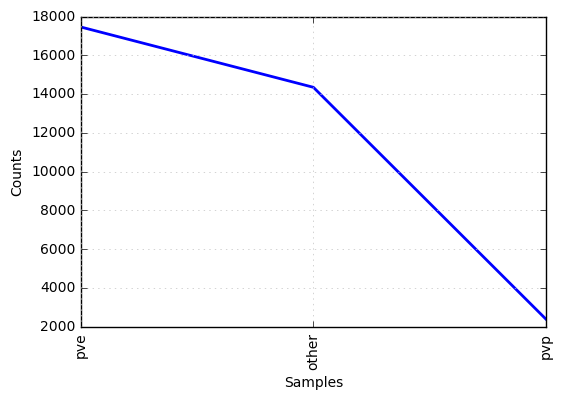

None
Demon Hunter
  pve other   pvp 
 6240  4750   926 
None


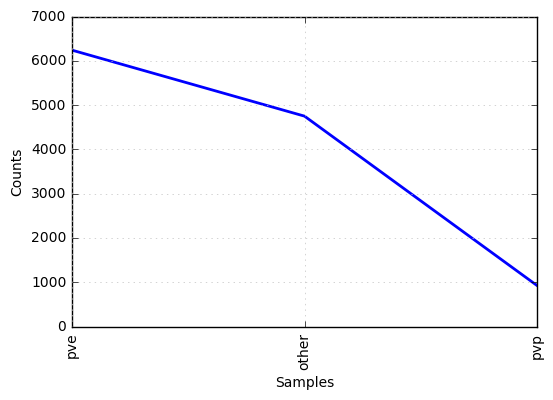

None


In [24]:
# plot histogram of findings
for wow_class in posts_with_game_type_dict:
    post_game_type_distribution = [post[4] for post in posts_with_game_type_dict.get(wow_class)]
    fdistGameType = nltk.FreqDist(post_game_type_distribution)
    print(wow_class)
    pprint(fdistGameType.tabulate())
    pprint(fdistGameType.plot())

In [ ]:
# READ ONTOLOGY
from owlready import *
onto_path.clear()
#onto_path.append("./Resources/")
wowOnto = get_ontology('file://Resources/Ontology/OWLXML.owl').load(True)

print(wowOnto.classes)
print(to_owl(wowOnto))